In [ ]:
import random

import tqdm
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow_docs.vis import embed
from tensorflow.keras.utils import to_categorical

import imageio

from IPython import display
from urllib import request

import matplotlib.pyplot as plt


In [ ]:

IMG_SIZE = (224, 224)

# Train és Test mappa elérési útjai
train_path = r"C:\Szakdolgozat\kozlekedesi_tabla_felismero\Database\Train"
test_path = r"C:\Szakdolgozat\kozlekedesi_tabla_felismero\Database\Test"

num_classes = 476

In [ ]:

# Osztályok betöltése


# Train adatok beolvasása
train_images, train_labels = load_dataset(train_path, IMG_SIZE)

def load_dataset(data_path, img_size):
    
    class_names = sorted(os.listdir(train_path))  # Az osztályokat rendezetten beolvassuk
    num_classes = len(class_names)
    print(f"Osztályok száma {train_path}: {num_classes}")
    
    images = []
    labels = []

    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(train_path, class_name)
        image_files = os.listdir(class_folder)
        
        for image_file in image_files:
            image_path = os.path.join(class_folder, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Átméretezés
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV BGR-ről RGB-re
            images.append(image)
            labels.append(class_index)  

# Test adatok beolvasása
test_images = []
test_labels = []

for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(test_path, class_name)
    image_files = os.listdir(test_path)
    
for image_file in image_files[:10]:
    image_path = os.path.join(test_path, image_file)
    print(image_path) 



print(f"Betöltött {len(train_images)} tanító és {len(test_images)} teszt kép.")


In [101]:
# Load videos 

import os 
import glob

dataset = []
video_filenames = []

for fn in glob.glob("../Videos/*"):
    video_filenames.append(fn)

In [ ]:
for filename in video_filenames:
    with open(f"../Annotations/{filename[10:-4]}.csv", "w") as f:
        pass


In [138]:
class_names = ["timestamp", "stop", "15", 
               "30", "50", "70", 
               "80", "90", "100", 
               "110", "120"]

In [ ]:

df = pd.DataFrame(
    data=np.zeros((1000, len(class_names)), dtype=int),
    columns=class_names)
df["timestamp"] = [x/2 for x in range(0, 1000, 1)] # TODO: set to video max frame count * x

df

for filename in video_filenames:    
    with open(f"../Annotations/{filename[10:-4]}.csv", "w") as f:
        df.to_csv(f, index=False)


In [144]:

for filename in video_filenames:
    src = cv2.VideoCapture(str(filename))  
    print("FPS per video:", src.get(cv2.CAP_PROP_FPS ))
    print("Frame per video:",src.get(cv2.CAP_PROP_FRAME_COUNT))
    print("bitrate:",src.get(cv2.CAP_PROP_BITRATE)) 

FPS per video: 29.913164283269055
Frame per video: 934.0
bitrate: 8029.0
FPS per video: 29.975428773108543
Frame per video: 1089.0
bitrate: 7674.0
FPS per video: 29.924540416209524
Frame per video: 1131.0
bitrate: 5891.0
FPS per video: 29.827707908187787
Frame per video: 1086.0
bitrate: 6640.0
FPS per video: 29.89431779312885
Frame per video: 1075.0
bitrate: 5509.0
FPS per video: 28.180242029001935
Frame per video: 1022.0
bitrate: 5759.0
FPS per video: 27.748640991037576
Frame per video: 960.0
bitrate: 5945.0
FPS per video: 29.73278405008539
Frame per video: 1098.0
bitrate: 7031.0
FPS per video: 29.86431636321466
Frame per video: 1073.0
bitrate: 3653.0
FPS per video: 29.71726964045733
Frame per video: 928.0
bitrate: 4562.0
FPS per video: 29.69452722957455
Frame per video: 946.0
bitrate: 5571.0
FPS per video: 29.795211519733485
Frame per video: 857.0
bitrate: 7147.0
FPS per video: 29.605197622552545
Frame per video: 743.0
bitrate: 6528.0
FPS per video: 29.77408909896163
Frame per video:

In [102]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def frames_from_video_file(video_path, n_frames=None, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  result = []
  src = cv2.VideoCapture(str(video_path))  
  
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  
  if not n_frames:
    n_frames = 1 + (video_length - 1) // frame_step

  need_length = 1 + (n_frames - 1) * frame_step

  # if need_length > video_length:
  #   start = 0
  # else:
  #   max_start = video_length - need_length
  #   start = random.randint(0, max_start + 1)
  
  start = 0

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    # ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
      
  src.release()
  
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [128]:
sample_video = frames_from_video_file(video_filenames[5], n_frames = 100)
sample_video.shape

(100, 224, 224, 3)

In [129]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


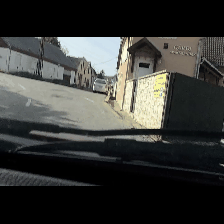

In [130]:
to_gif(sample_video)

In [ ]:
class FrameGenerator:
  def __init__(self, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.training = training
    
    self.class_names = sorted(set(p.name for p in video_filenames.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def __call__(self):

    if self.training:
      random.shuffle()

    for path, name in pairs:
      video_frames = frames_from_video_file(path) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
fg = FrameGenerator(training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(#  10, 
                                                         training=True),
                                          output_signature = output_signature)

In [ ]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(training=False),
                                        output_signature = output_signature)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

In [ ]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

In [ ]:
# Átalakítás numpy tömbökké
train_images = np.array(train_images) / 255.0  # Normalizálás
test_images = np.array(test_images) / 255.0

train_labels = to_categorical(train_labels, num_classes)  # One-hot encoding
test_labels = to_categorical(test_labels, num_classes)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, mean_squared_log_error, \
    root_mean_squared_error

# Neural Network with TensorFlow

device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")

# Hyperparameters
batch_size = 256

activation_func = 'relu'

def scheduler(epoch, lr):
    if epoch < 550:
        return lr
    else:
        return lr * np.exp(-0.1)

num_epochs = 50
learning_rate = 1.5e-4
criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_images, dtype=tf.float32),
                                                    tf.convert_to_tensor(train_labels, dtype=tf.float32)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_images, dtype=tf.float32),
                                                    tf.convert_to_tensor(test_labels, dtype=tf.float32)))

train_loader = train_dataset.batch(batch_size, drop_remainder=True) # .shuffle(buffer_size=len(train_images))
val_loader = val_dataset.batch(batch_size, drop_remainder=True) # .shuffle(buffer_size=len(test_images))



Using device: CPU


In [ ]:

class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = tf.keras.layers.Dense((IMG_SIZE, IMG_SIZE, batch_size), activation=activation_func)

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))

        self.hidden_layers = []
        for i in range(7):
            self.hidden_layers.append(tf.keras.layers.Dense(512, activation=activation_func))
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())

        # self.additional_layers = []
        # for i in range(2):
        #     self.additional_layers.append(tf.keras.layers.Dense(256, activation=activation_func))
        #     self.additional_layers.append(tf.keras.layers.Dropout(0.2))

        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.input_layer(x)
        # for layer in self.feature_extractor:
        #     x = layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        # for layer in self.additional_layers:
        #     x = layer(x)

        return self.output_layer(x)
    

model = Net()

In [ ]:


train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_loader):
        with tf.GradientTape() as tape:
            outputs = model(batch_x, training=True)
            loss = criterion(batch_y, tf.squeeze(outputs))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_loss += loss.numpy()

    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    val_loss = 0
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x, training=False)
        loss = criterion(batch_y, tf.squeeze(outputs))
        val_loss += loss.numpy()

    val_losses.append(val_loss / len(val_loader))

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss / len(val_loader):.4f}"
    )

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Making predictions
x_train_tensor = tf.convert_to_tensor(train_dataset, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(val_dataset, dtype=tf.float32)

y_train_pred = model(x_train_tensor, training=False).numpy()
y_test_pred = model(x_test_tensor, training=False).numpy()


Epoch 1/50


ValueError: Exception encountered when calling Net.call().

[1mInvalid dtype: tuple[0m

Arguments received by Net.call():
  • x=tf.Tensor(shape=(256, 32, 32, 3), dtype=float32)

In [ ]:

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train R-squared: {train_r2 * 100:.2f}%')
print(f'Test R-squared: {test_r2 * 100:.2f}%')
print(f'Test Mean Squared Error (MSE): {test_mse:.2f}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse:.2f}')
print(f'Test Mean Absolute Error (MAE): {test_mae:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', marker='o', linestyle='None')
plt.plot(y_test_pred, label='Predicted', marker='x', linestyle='None')
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

print(model.summary())
print(model.get_config())
print(optimizer.get_config())

model.save("HousePrices/saved_models/nn_model_" + exp_name + ".tf",
            save_format='tf')